# Проект: Анализ пользовательского спроса на Яндекс Афише (Осень 2024)

- Автор: Иванова Оксана Владимировна
- Дата: 03.06.2025

## Цель проекта:  
Выявление факторов, влияющих на изменение пользовательского спроса на билеты Яндекс Афиши в период с 1 июня по 30 октября 2024 года, а также определение различий в поведении пользователей с мобильных и стационарных устройств.


## Задачи проекта:
- Предобработка данных: Загрузка, изучение и очистка данных из 3 датасетов. Объединение данных и конвертация валюты в рубли.
- Анализ общих трендов: Динамика заказов и выручки, типы мероприятий, средние значения.Популярные события, организаторы, площадки.
- Анализ поведения пользователей по устройствам: Сравнение заказов, выручки, среднего чека и предпочтений. Определение частоты покупок.
- Проверка гипотез: Анализ различий между мобильными и стационарными устройствами.
- Визуализация: Создание графиков и диаграмм для представления результатов.
- Выводы и рекомендации: Обобщение результатов и рекомендации для продуктовой команды.

## Описание данных

final_tickets_orders_df.csv: Содержит информацию о заказах билетов, включая:

order_id: Уникальный идентификатор заказа.  
user_id: Уникальный идентификатор пользователя.  
created_dt_msk: Дата создания заказа (московское время).  
created_ts_msk: Дата и время создания заказа (московское время).  
event_id: Идентификатор мероприятия из таблицы events.  
cinema_circuit: Сеть кинотеатров (или “нет”).  
age_limit: Возрастное ограничение мероприятия.  
currency_code: Валюта оплаты (rub, kzt).  
device_type_canonical: Тип устройства (mobile, desktop).  
revenue: Выручка от заказа.  
service_name: Название билетного оператора.  
tickets_count: Количество купленных билетов.  
total: Общая сумма заказа.  
days_since_prev: Количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

final_tickets_events_df.csv: Содержит информацию о мероприятиях, включая:

event_id: Уникальный идентификатор мероприятия.  
event_name: Название мероприятия.  
event_type_description: Описание типа мероприятия.  
event_type_main: Основной тип мероприятия (театральная постановка, концерт и т.д.).  
organizers: Организаторы мероприятия.  
region_name: Название региона.  
city_name: Название города.  
venue_id: Уникальный идентификатор площадки.  
venue_name: Название площадки.  
venue_address: Адрес площадки.

final_tickets_tenge_df.csv: Содержит информацию о курсе тенге к российскому рублю, включая:

nominal: Номинал (100 тенге).  
data: Дата.  
curs: Курс тенге к рублю (за 100 тенге).  
cdx: Обозначение валюты (kzt).

Дополнительная информация:
- Датасеты предполагают, что для анализа требуется только временной период с 01.06.2024 по 30.10.2024.
- Успешный проект позволит выявить ключевые факторы, влияющие на динамику спроса, и предоставить ценную информацию для улучшения работы сервиса Яндекс Афиша.

## Загрузка данных и знакомство с ними

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


Загрузим данные и выведем сводную информацию:

In [2]:
# Загрузка данных
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')


In [3]:
# Знакомство с данными
dataframes = {
    'orders': orders_df,
    'events': events_df,
    'tenge': tenge_df
}

for name, df in dataframes.items():
    print(f"\nДатасет: {name.upper()}")
    print("Размерность:", df.shape)
    print("\nПервые 5 строк:")
    display(df.head())
    df.info()
    


Датасет: ORDERS
Размерность: (290849, 14)

Первые 5 строк:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB

Датасет: TENGE
Размерность: (357, 4)

Первые 5 строк:


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Промежуточные выводы по анализу данных:
- Данные в целом соответствуют описанию, но требуют предобработки для дальнейшего анализа.

Детальный анализ датасетов:

ORDERS (Заказы):

Размерность: (290849, 14) - достаточно большой датасет. Присутствуют как числовые, так и строковые типы. Столбцы created_dt_msk и created_ts_msk необходимо преобразовать в формат даты/времени.
days_since_prev: содержит пропуски (268909 non-null). Необходимо решить, как заполнить пропуски или исключить эти строки из анализа, если это необходимо.
Необходимо проверить на дубликаты по order_id.
Проверить распределение age_limit и tickets_count (возможно, есть выбросы).

EVENTS (Мероприятия):

Размерность: (22427, 11)
Типы данных в основном строковые и целочисленные.
Необходимо проверить на дубликаты по event_id.

TENGE (Курсы тенге):

Размерность: (357, 4) - небольшой датасет.
Типы данных: даты, числовые и строковые.
data: необходимо преобразовать в формат даты.

## Предобработка данных и подготовка их к исследованию

Проверим все датасеты на пропуски:

In [4]:
# Проверка на пропуски
print('Проверка пропусков:')
for df_name, df in {'orders': orders_df, 'events': events_df, 'tenge': tenge_df}.items():
    print(f'\n{df_name}:')
    print(df.isna().sum())

Проверка пропусков:

orders:
order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

events:
event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

tenge:
data       0
nominal    0
curs       0
cdx        0
dtype: int64


Выгрузка данных из SQL прошла успешно. Кроме столбца days_since_prev (21940 пропусков), данные не содержат пропуски.

Заменим пропуски в стобце 'days_since_prev' нулем

In [5]:
orders_df['days_since_prev'] = orders_df['days_since_prev'].fillna(0)

Для удобства перед обработкой данных объединим датасеты: orders_df и events_df

In [6]:
# Объединение данных по event_id
full_df = orders_df.merge(events_df, on='event_id', how='left')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         290849 non-null  float64
 14  event_name          

Проверим пропуски после объединения датасетов

In [7]:
# Проверка пропусков
print("\nПропуски после объединения:")
print(full_df.isnull().sum())


Пропуски после объединения:
order_id                    0
user_id                     0
created_dt_msk              0
created_ts_msk              0
event_id                    0
cinema_circuit              0
age_limit                   0
currency_code               0
device_type_canonical       0
revenue                     0
service_name                0
tickets_count               0
total                       0
days_since_prev             0
event_name                238
event_type_description    238
event_type_main           238
organizers                238
region_name               238
city_name                 238
city_id                   238
venue_id                  238
venue_name                238
venue_address             238
dtype: int64


После объединения появились пропуски в столбцах (238 строк), перенесенных из events_df (например, event_name, event_type_description и т.д.). Это говорит о том, что в orders_df есть event_id, которого нет в events_df. Это может быть связано с тем, что некоторые события были удалены из events_df.

238 строк из 290849 - это очень небольшой процент, так что удаление может быть приемлемым вариантом

In [8]:
full_df = full_df.dropna(subset=['event_name'])
# Проверка пропусков
print("\nПропуски после объединения:")
print(full_df.isnull().sum())


Пропуски после объединения:
order_id                  0
user_id                   0
created_dt_msk            0
created_ts_msk            0
event_id                  0
cinema_circuit            0
age_limit                 0
currency_code             0
device_type_canonical     0
revenue                   0
service_name              0
tickets_count             0
total                     0
days_since_prev           0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64


 Проведем анализ категориальных переменных 

In [9]:
# Анализ категориальных данных
categorical_cols = ['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name']
for col in categorical_cols:
    print(f"\nКатегории в столбце {col}:")
    print(full_df[col].value_counts())



Категории в столбце cinema_circuit:
cinema_circuit
нет           289213
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: count, dtype: int64

Категории в столбце age_limit:
age_limit
16    78556
12    62474
0     61487
6     52161
18    35933
Name: count, dtype: int64

Категории в столбце currency_code:
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

Категории в столбце device_type_canonical:
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

Категории в столбце service_name:
service_name
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За б

В столбце (cinema_circuit) — сеть кинотеатров,встречается слово 'нет', что означает отсутствие информации или отсутствии сети.

Нормализуем данные. Приведем service_name к нижнему регистру 

In [10]:
# Приведение service_name к нижнему регистру 
full_df['service_name'] = full_df['service_name'].str.lower()
print(full_df['service_name'].value_counts())

service_name
билеты без проблем        63519
лови билет!               41124
билеты в руки             40343
мой билет                 34839
облачко                   26642
лучшие билеты             17774
весь в билетах            16849
прачечная                 10273
край билетов               6207
тебе билет!                5228
яблоко                     5039
дом культуры               4502
за билетом!                2865
городской дом культуры     2733
show_ticket                2200
мир касс                   2167
быстробилет                2003
выступления.ру             1616
восьмёрка                  1118
crazy ticket!               790
росбилет                    539
шоу начинается!             499
быстрый кассир              381
радио ticket                376
телебилет                   321
карандашру                  133
реестр                      125
билет по телефону            85
вперёд!                      80
дырокол                      74
кино билет                 

Посмотрим на распределение и наличие выбросов в таком важном показателе, как выручка с заказа (revenue).

In [11]:
# Анализ и обработка выбросов в revenue
print("\nАнализ выбросов в revenue:")
print(full_df['revenue'].describe())


Анализ выбросов в revenue:
count    290611.000000
mean        625.584360
std        1227.693064
min         -90.760000
25%         116.850000
50%         356.010000
75%         810.130000
max       81174.540000
Name: revenue, dtype: float64


Существуют как минимум два типа выбросов:
Отрицательные значения: min         -90.760000.
Большие значения: max       81174.540000. Вероятно, тоже выбросы. 

Поскольку данные изначально были представлены в разных валютах, поэтому разделим анализ на рубли и тенге

In [12]:
# Разделение данных по валюте
rub_orders = full_df[full_df['currency_code'] == 'rub'].copy()
kzt_orders = full_df[full_df['currency_code'] == 'kzt'].copy()

Проанализируем визуально распределение выручки в руб. с помощью графика boxplot.

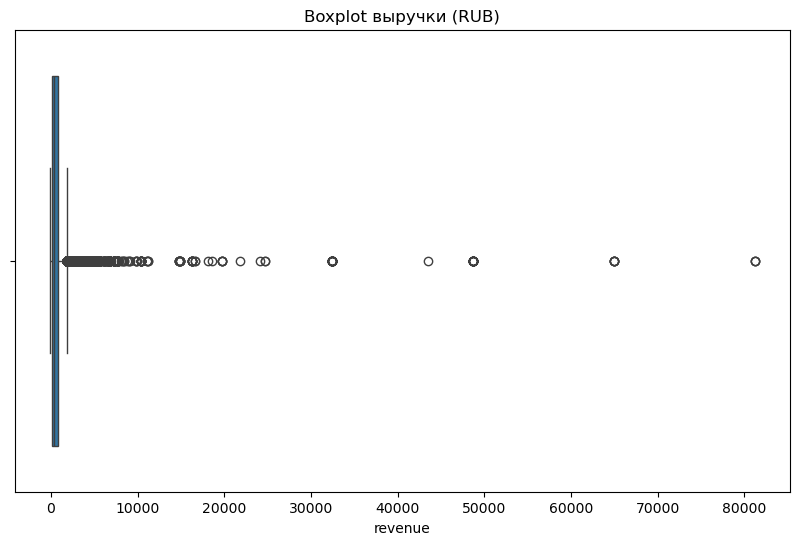

In [13]:
# Анализ выбросов для рублей
plt.figure(figsize=(10, 6))
sns.boxplot(x=rub_orders['revenue'])
plt.title('Boxplot выручки (RUB)')
plt.show()

Удалим отрицательные выбросы:

In [14]:
# Обработка отрицательных значений
rub_orders = rub_orders[rub_orders['revenue'] >= 0]

Удалим выбросы используя значения по 99-му процентилю


Выбросы удалены. Порог для revenue (RUB): 2570.8
count    282361.000000
mean        511.501020
std         500.914811
min           0.000000
25%         113.020000
50%         341.710000
75%         782.410000
max        2570.800000
Name: revenue, dtype: float64


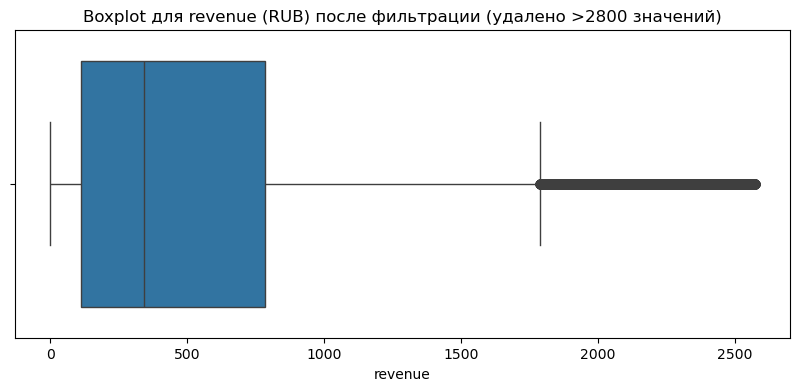

In [15]:
revenue_threshold_rub = rub_orders['revenue'].quantile(0.99)
rub_orders_filtered = rub_orders[rub_orders['revenue'] <= revenue_threshold_rub]

print(f'\nВыбросы удалены. Порог для revenue (RUB): {revenue_threshold_rub}')
print(rub_orders_filtered['revenue'].describe())
plt.figure(figsize=(10, 4))
sns.boxplot(x=rub_orders_filtered['revenue'])
plt.title(f'Boxplot для revenue (RUB) после фильтрации (удалено >{len(rub_orders) - len(rub_orders_filtered)} значений)')

plt.show()

После фильтрации удалено более 2800 значений.

Проанализируем визуально распределение выручки в тенге с помощью графика boxplot.


Анализ выбросов в revenue (KZT):
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


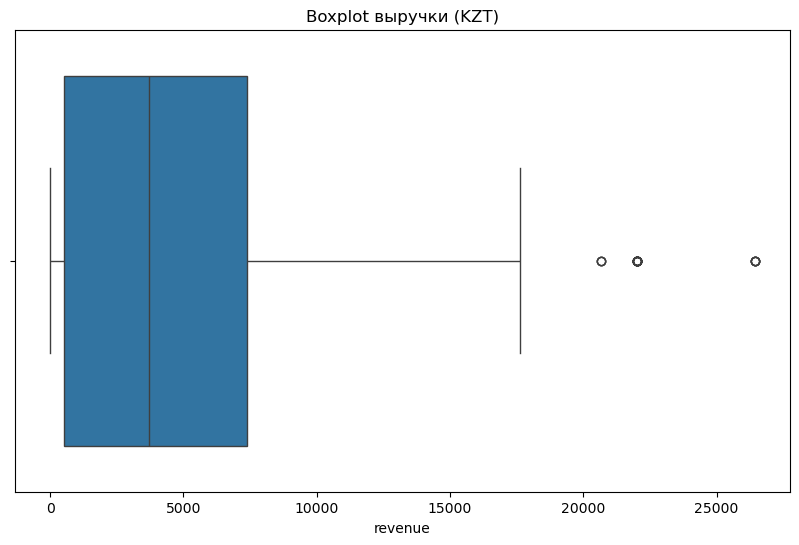

In [16]:
# Анализ выбросов для тенге
print("\nАнализ выбросов в revenue (KZT):")
print(kzt_orders['revenue'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x=kzt_orders['revenue'])
plt.title('Boxplot выручки (KZT)')
plt.show()

Стандартное отклонение (std) почти такое же, как среднее (mean), указывает на значительный разброс данных. Максимальное значение (26425.86) значительно отличается от 75% квартиля (7397.66), что указывает на выбросы.

Удалим выбросы используя значения по 99-му процентилю


Выбросы удалены. Порог для revenue (KZT): 17617.24
count     5040.000000
mean      4893.669063
std       4742.680176
min          0.000000
25%        515.350000
50%       3698.830000
75%       7397.660000
max      17617.240000
Name: revenue, dtype: float64


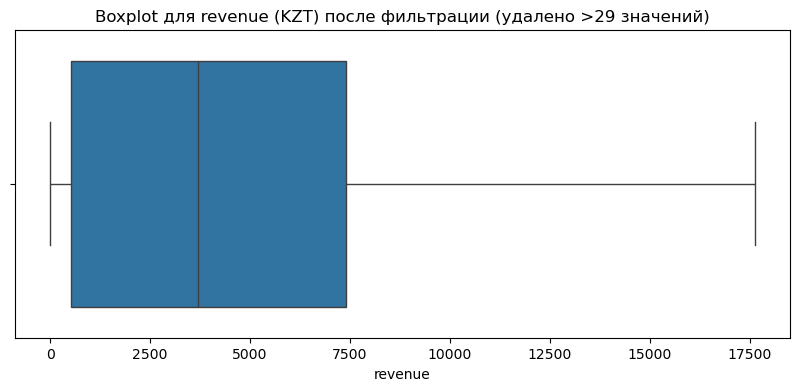

In [17]:
revenue_threshold_kzt = kzt_orders['revenue'].quantile(0.99)
kzt_orders_filtered = kzt_orders[kzt_orders['revenue'] <= revenue_threshold_kzt]

print(f'\nВыбросы удалены. Порог для revenue (KZT): {revenue_threshold_kzt}')
print(kzt_orders_filtered['revenue'].describe())
plt.figure(figsize=(10, 4))
sns.boxplot(x=kzt_orders_filtered['revenue'])
plt.title(f'Boxplot для revenue (KZT) после фильтрации (удалено >{len(kzt_orders) - len(kzt_orders_filtered)} значений)')
plt.show()

После фильтрации удалено более 29 значений.

Посмотрим на распределение и наличие выбросов в еще одном важном показателе, как выручка количество билетов в заказе (tickets_count).

In [18]:
# Анализ выбросов для tickets_count 
print("\nАнализ выбросов в tickets_count:")
print(full_df['tickets_count'].describe())


Анализ выбросов в tickets_count:
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


max (57) существенно отличается от других значений, указывая на потенциальные выбросы

Проанализируем визуально распределение количества билетов с помощью графика boxplot.

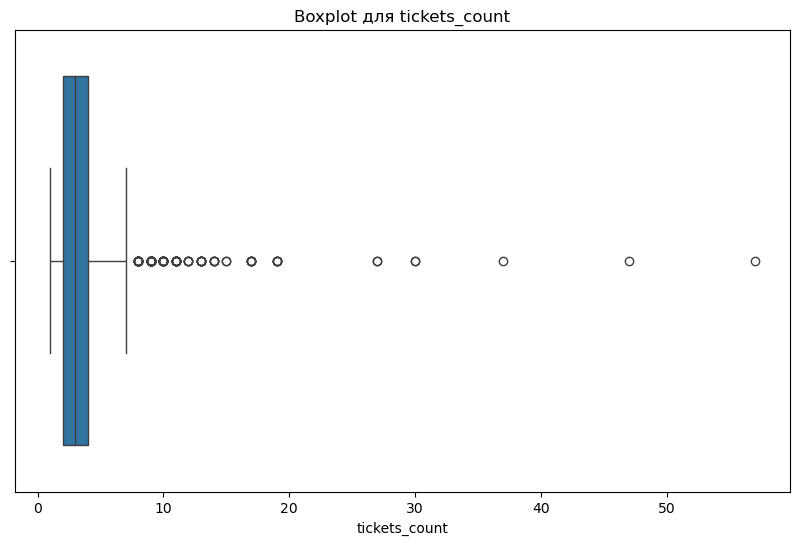

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=full_df['tickets_count'])
plt.title('Boxplot для tickets_count')
plt.show()

Удалим выбросы используя значения по 99-му процентилю


Выбросы удалены. Порог для tickets_count: 6.0
count    290423.000000
mean          2.749366
std           1.143899
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64


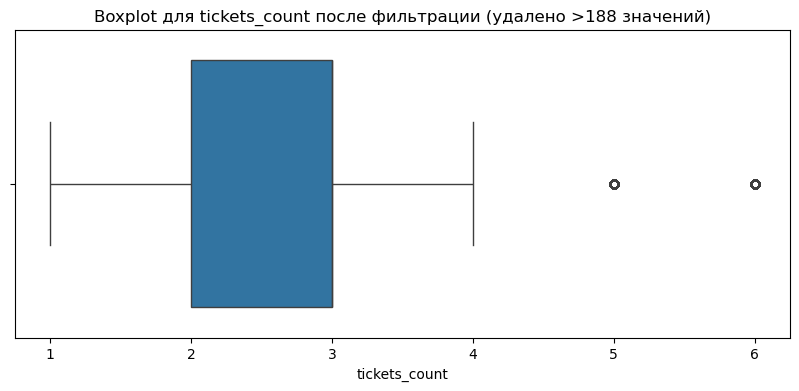

In [20]:
tickets_count_threshold = full_df['tickets_count'].quantile(0.99)
orders_filtered = full_df[full_df['tickets_count'] <= tickets_count_threshold]

print(f'\nВыбросы удалены. Порог для tickets_count: {tickets_count_threshold}')
print(orders_filtered['tickets_count'].describe())
plt.figure(figsize=(10, 4))
sns.boxplot(x=orders_filtered['tickets_count'])
plt.title('Boxplot для tickets_count после фильтрации')
plt.title(f'Boxplot для tickets_count после фильтрации (удалено >{len(full_df) - len(orders_filtered)} значений)')
plt.show()

После фильтрации удалено более 188 значений.

Проверим явные дубликаты в объединенном датасете:

In [21]:
print(f"Количество дубликатов: {full_df.duplicated().sum()}")

Количество дубликатов: 0


Явных дубликатов не обнаружено

Проверим неявные дубликаты:

In [22]:
# Проверка неявных дубликатов:

# Определим колонки, которые описывают бронирование билета, исключая идентификатор order_id
booking_columns = ['user_id','created_dt_msk', 'event_id', 'cinema_circuit',
                   'device_type_canonical', 'service_name', 'revenue', 'total']

# Группируем данные по выбранным колонкам и считаем количество одинаковых бронирований
duplicates = full_df.groupby(booking_columns).size().reset_index(name='count')

# Выводим бронирования, которые встречаются больше одного раза
duplicate_bookings = duplicates[duplicates['count'] > 1].sort_values(by='count', ascending=False)

print("\nНеявные дубликаты (одинаковые бронирования):")
print(duplicate_bookings)


Неявные дубликаты (одинаковые бронирования):
                user_id created_dt_msk  event_id cinema_circuit  \
75089   4226e240b0f7a38     2024-09-03    428762            нет   
75088   4226e240b0f7a38     2024-09-03    428762            нет   
143261  8d6c1ff89fac35f     2024-10-31    589624            нет   
122466  7b9888ec96c5fb6     2024-10-01    574431            нет   
143260  8d6c1ff89fac35f     2024-10-31    589624            нет   
...                 ...            ...       ...            ...   
238416  ffc4133fbba20f4     2024-06-21    533803            нет   
238375  ffa3834ba47a815     2024-08-02    536131            нет   
238374  ff9ee83de561430     2024-06-27    541879            нет   
238369  ff94afeb0399f7c     2024-10-06    546107            нет   
238351  ff9310a90294d5c     2024-10-27    549373            нет   

       device_type_canonical        service_name  revenue     total  count  
75089                desktop       билеты в руки   203.95   3399.22     

Обнаружено 32504 неявных дубликатов. Из данных видно, что пользователь может забронировать несколько билетов на один и тот же фильм, в один и тот же сеанс, с одного и того же устройства, и т.д.
Решение: Оставим данные как есть, поскольку каждая строка представляет собой транзакцию, и если пользователь купил несколько билетов в рамках одной транзакции, то каждая строка должна быть учтена. 

Преобразуем типы данных в колонках датасетов с датой:

In [23]:
# Преобразуем колонку с датой и временем
full_df['created_ts_msk'] = pd.to_datetime(full_df['created_ts_msk'])
full_df['created_dt_msk'] = pd.to_datetime(full_df['created_dt_msk'])

# Преобразуем колонку с датой
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

Проведем снижение размерности количественных данных

In [24]:
# Приводим числовые колонки к оптимальным типам для экономии памяти
for col in full_df.select_dtypes(include=['number']):
    full_df[col] = pd.to_numeric(full_df[col], downcast='integer') # Целочисленные колонки
for col in ['revenue','total','tickets_count']:
  orders_df[col] = pd.to_numeric(full_df[col], downcast='float') # Преобразуем эти колонки в float32 для экономии памяти

for col in ['nominal','curs']:
    tenge_df[col] = pd.to_numeric(tenge_df[col], downcast='float')
    
    # Выводим обновленный orders_df
print("\nОбновленный full_df:")
full_df.info() # Выводим информацию об обновленном датафрейме


Обновленный full_df:
<class 'pandas.core.frame.DataFrame'>
Index: 290611 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total        

In [25]:
# Выводим информацию о tenge_df
print("\nИнформация о tenge_df:")
tenge_df.info()


Информация о tenge_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    float32       
 2   curs     357 non-null    float32       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float32(2), object(1)
memory usage: 8.5+ KB


После преобразований данные и память были оптимизированы

Для приведения выручки с заказа к единой валюте — российскому рублю, создадим новые столбцы: revenue_rub и one_ticket_revenue_rub — где рассчитаем выручку с продажи одного билета на мероприятие.А также проведем конвертацию тенге.

In [26]:
# Создаем словарь курсов валют
exchange_rates = {}
for _, row in tenge_df.iterrows():
    exchange_rates[row['data'].date()] = row['curs'] / 100  # курс за 1 тенге

# Функция для конвертации валюты
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        date = row['created_dt_msk'].date()
        if date in exchange_rates:
            return row['revenue'] * exchange_rates[date]
        else:
            # Если курс на эту дату не найден, возвращаем NaN
            return np.nan
    else:
        return np.nan

full_df['revenue_rub'] = full_df.apply(convert_to_rub, axis=1)
full_df = full_df.dropna(subset=['revenue_rub'])


# one_ticket_revenue_rub
full_df['one_ticket_revenue_rub'] = full_df['revenue_rub'] / full_df['tickets_count']

Выделим месяц оформления заказа в отдельный столбец.

In [27]:
# month
full_df['month'] = full_df['created_dt_msk'].dt.month

Создадим столбец 'season' с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.


In [28]:
# season
def get_season(month):
    if 3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'

full_df['season'] = full_df['month'].apply(get_season)

# Вывод обновленного датафрейма
full_df.info()
full_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 290611 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611 non-

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.41,463.4700,10,осень


Промежуточные выводы после предобработки данных:
- Для удобства перед обработкой данных проведено объединение  датасетов: orders_df и events_df. После объединения было обнаружено небольшое количество пропусков, которые были удалены.
- Была проведена обширная предобработка данных, включающая преобразование типов, поиск дубликатов (явных и неявных), обработку выбросов, оптимизацию данных и создание новых признаков для дальнейшего анализа. 
- Обнаружено 32504 неявных дубликатов. Принято решение оставить данные как есть, поскольку каждая строка представляет собой транзакцию, и если пользователь купил несколько билетов в рамках одной транзакции, то каждая строка должна быть учтена. 
- Для дальнейшего анализа созданы новые столбцы: revenue_rub — выручка с заказа в единой валюте (руб.) и one_ticket_revenue_rub — выручка с продажами одного билета на мероприятие. Также были созданы новые столбцы: month для выделения месяца оформления заказа в отдельный столбец и season — с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

Проведем анализ динамики заказов от июня до ноября 2024 года.

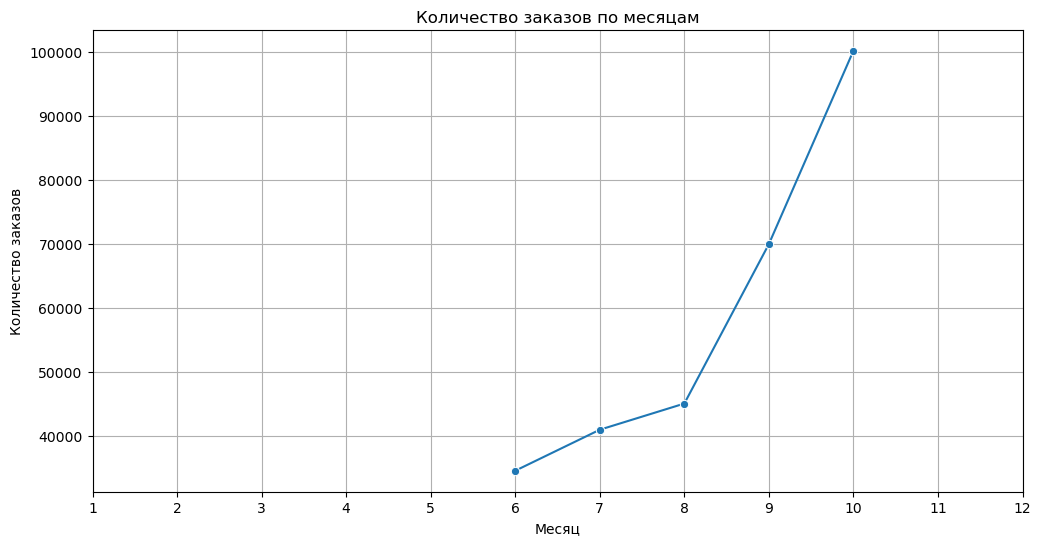

In [29]:
# Анализ динамики заказов по месяцам

# Рассчитывается общее количество заказов для каждого месяца.
orders_by_month = full_df.groupby('month')['order_id'].count().reset_index()
orders_by_month.rename(columns={'order_id': 'order_count'}, inplace=True)

# Построение линейного графика количества заказов по месяцам.
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='order_count', data=orders_by_month, marker='o')
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

Фиксируется увеличение заказов в интервале от июня до ноября 2024 года.

Для осеннего и летнего периодов сравним распределение заказов билетов 

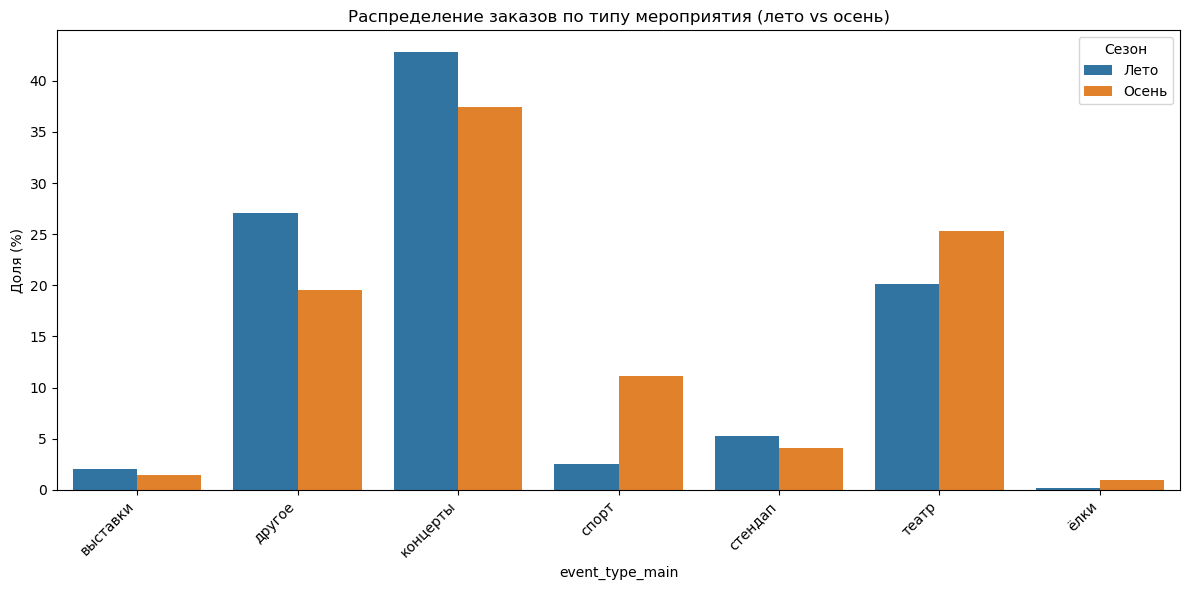

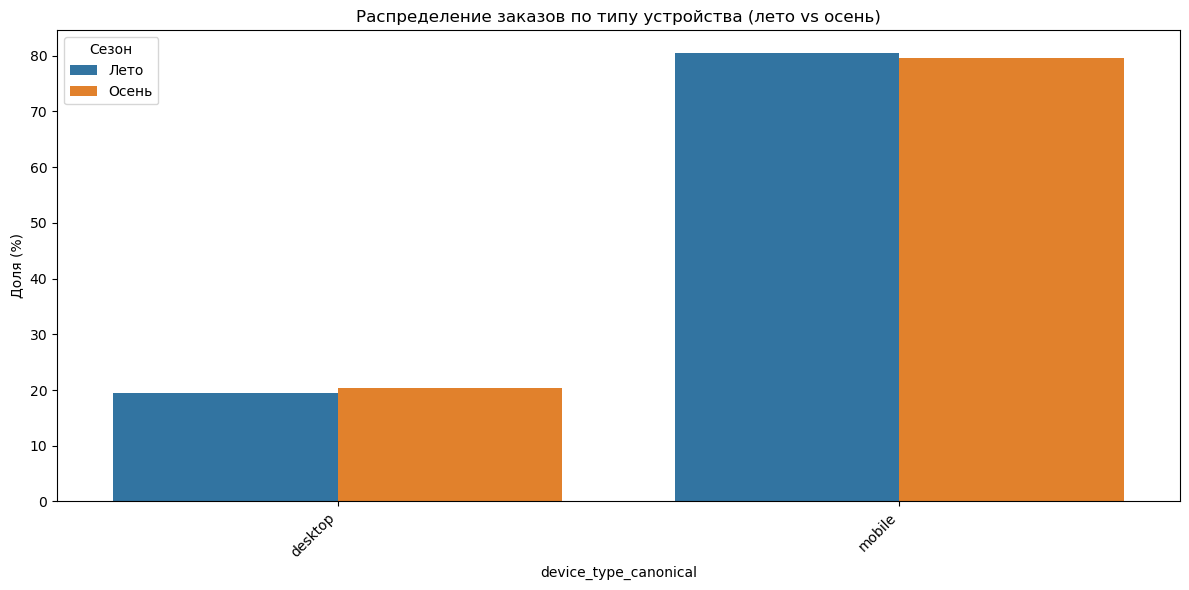

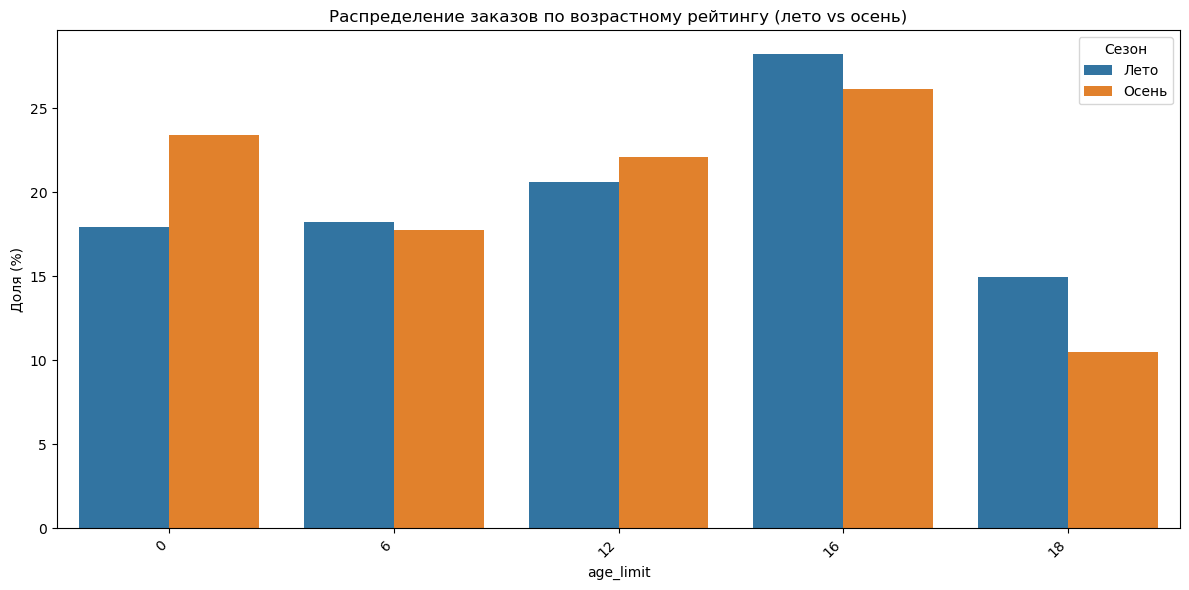

In [30]:
# Фильтруем данные для летних заказов.
summer_orders = full_df[full_df['season'] == 'лето']

# Фильтруем данные для осенних заказов.
autumn_orders = full_df[full_df['season'] == 'осень']


def plot_seasonal_distribution(df_summer, df_autumn, column, title):
    """
    Функция для построения графиков распределения по сезонам.
    """
    # Группируем летние заказы по указанному столбцу и считаем количество заказов.
    summer_counts = df_summer.groupby(column)['order_id'].count()
    # Группируем осенние заказы по указанному столбцу и считаем количество заказов.
    autumn_counts = df_autumn.groupby(column)['order_id'].count()

    # Вычисляем общее количество заказов для лета и осени.
    total_summer = len(df_summer)
    total_autumn = len(df_autumn)

    # Вычисляем процентное распределение для лета.
    summer_percentages = (summer_counts / total_summer) * 100
    # Вычисляем процентное распределение для осени.
    autumn_percentages = (autumn_counts / total_autumn) * 100

    # Создаем DataFrame для построения графика.
    df = pd.DataFrame({
        'Сезон': ['Лето'] * len(summer_percentages) + ['Осень'] * len(autumn_percentages),
        column: list(summer_percentages.index) + list(autumn_percentages.index),
        'Доля (%)': list(summer_percentages.values) + list(autumn_percentages.values)
    })

    # Строим столбчатый график для сравнения распределения по сезонам.
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column, y='Доля (%)', hue='Сезон', data=df)
    plt.title(title) 
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  # 
    plt.show()  
    
plot_seasonal_distribution(summer_orders, autumn_orders, 'event_type_main', 'Распределение заказов по типу мероприятия (лето vs осень)')
plot_seasonal_distribution(summer_orders, autumn_orders, 'device_type_canonical', 'Распределение заказов по типу устройства (лето vs осень)')
plot_seasonal_distribution(summer_orders, autumn_orders, 'age_limit', 'Распределение заказов по возрастному рейтингу (лето vs осень)')


Выводы: 
- Осенью наблюдается смещение интереса в сторону концертов, театра, спорта и ёлок, что может быть связано с изменениями погоды и началом нового сезона.
- Рост заказов наблюдается как с мобильных устройств, так и с настольных компьютеров осенью, что указывает на рост общего количества заказов. Увеличение доли заказов с мобильных устройств остается, но соотношение заказов с десктопов выросло.
- Осенью наблюдается общий рост заказов во всех возрастных категориях. Наиболее заметен рост в категории “0”, что может быть связано с увеличением количества мероприятий, подходящих для детей.

Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

Относительное изменение средней стоимости билета (осень по сравнению с летом) по типу мероприятия:

event_type_main
выставки    0.054151
другое     -0.049121
концерты   -0.101300
спорт      -0.036586
стендап     0.100820
театр      -0.177421
ёлки       -0.151542
Name: relative_change, dtype: float64


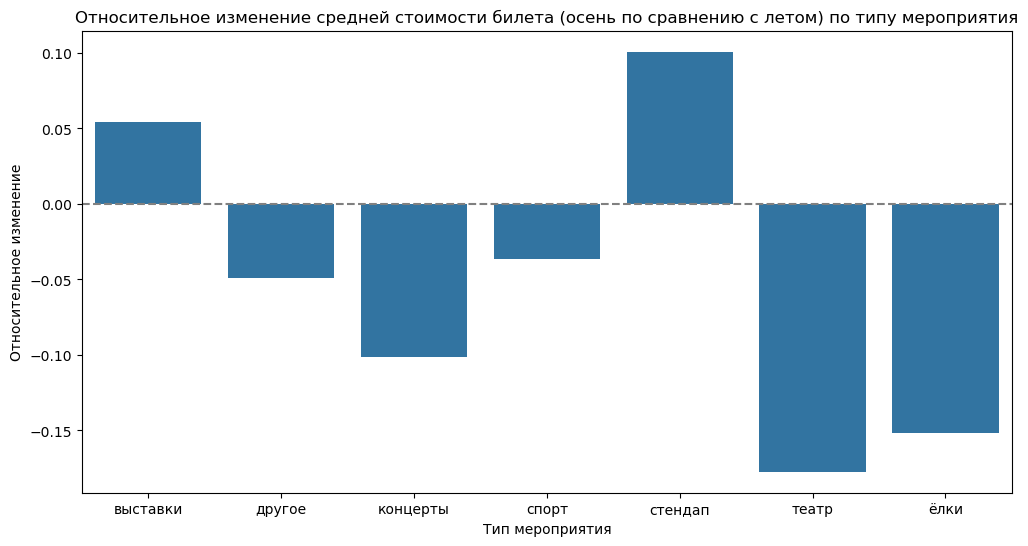

In [31]:
# Средняя выручка за билет по типу мероприятия в лето и осень
avg_revenue_by_event_type = full_df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().reset_index()

# Расчет относительного изменения осенних значений по сравнению с летними
pivot = avg_revenue_by_event_type.pivot(index='event_type_main', columns='season', values='one_ticket_revenue_rub')
pivot['relative_change'] = (pivot['осень'] - pivot['лето']) / pivot['лето']

# Вывод относительного изменения
print("Относительное изменение средней стоимости билета (осень по сравнению с летом) по типу мероприятия:\n")
print(pivot['relative_change'])

# Визуализация изменения
plt.figure(figsize=(12, 6))
sns.barplot(x=pivot.index, y=pivot['relative_change'])
plt.title('Относительное изменение средней стоимости билета (осень по сравнению с летом) по типу мероприятия')
plt.ylabel('Относительное изменение')
plt.xlabel('Тип мероприятия')
plt.axhline(0, color='gray', linestyle='--')
plt.show()


- Выставки и Стендап: Цена на эти типы мероприятий увеличилась осенью по сравнению с летом. Возможно, осенью проходят более премиальные или популярные выставки и стендапы.
- Другое, Концерты, Спорт, Театр, Ёлки: Цена на эти типы мероприятий снизилась осенью по сравнению с летом. Снижение может быть связано с сезонностью, изменением спроса или конкуренцией. Особенно заметно падение цен на “Театр” и “Ёлки”.

Общие выводы:

Осенью наблюдается повышенный интерес к развлекательным мероприятиям, особенно к театральным постановкам, спортивным событиям и концертам.
Средняя стоимость билета на разные типы мероприятий изменяется по-разному. В то время как стендап-мероприятия становятся дороже, стоимость билетов на театр, “ёлки” и концерты снижается. Это может быть связано с различными факторами, такими как сезонные скидки, изменения в программе мероприятий и т.д.

### Анализ осенней активности пользователей

Проанализируем динамику общего числа заказов за сентябрь и октябрь 2024

In [32]:
# Фильтрация данных за сентябрь и октябрь 2024
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2024-10-31')

autumn_df = full_df[(full_df['created_dt_msk'] >= start_date) & (full_df['created_dt_msk'] <= end_date)].copy()

Создадим одну сводную таблицу, и в ней по дням рассчитаем число заказов и число уникальных пользователей, а затем найти величину — количество заказов на одного пользователя.

In [33]:
# Создаем сводную таблицу
daily_summary = autumn_df.groupby(autumn_df['created_dt_msk'].dt.date).agg(
    total_orders=('order_id', 'count'),
    unique_users=('user_id', 'nunique'),
    total_revenue=('revenue_rub', 'sum'),
    total_tickets=('tickets_count', 'sum')
).reset_index()

daily_summary['avg_orders_per_user'] = daily_summary['total_orders'] / daily_summary['unique_users']
daily_summary['avg_ticket_price'] = daily_summary['total_revenue'] / daily_summary['total_tickets']
daily_summary = daily_summary.rename(columns={'created_dt_msk': 'date'})

Визуализируем полученные результаты с помощью линейного графика. 

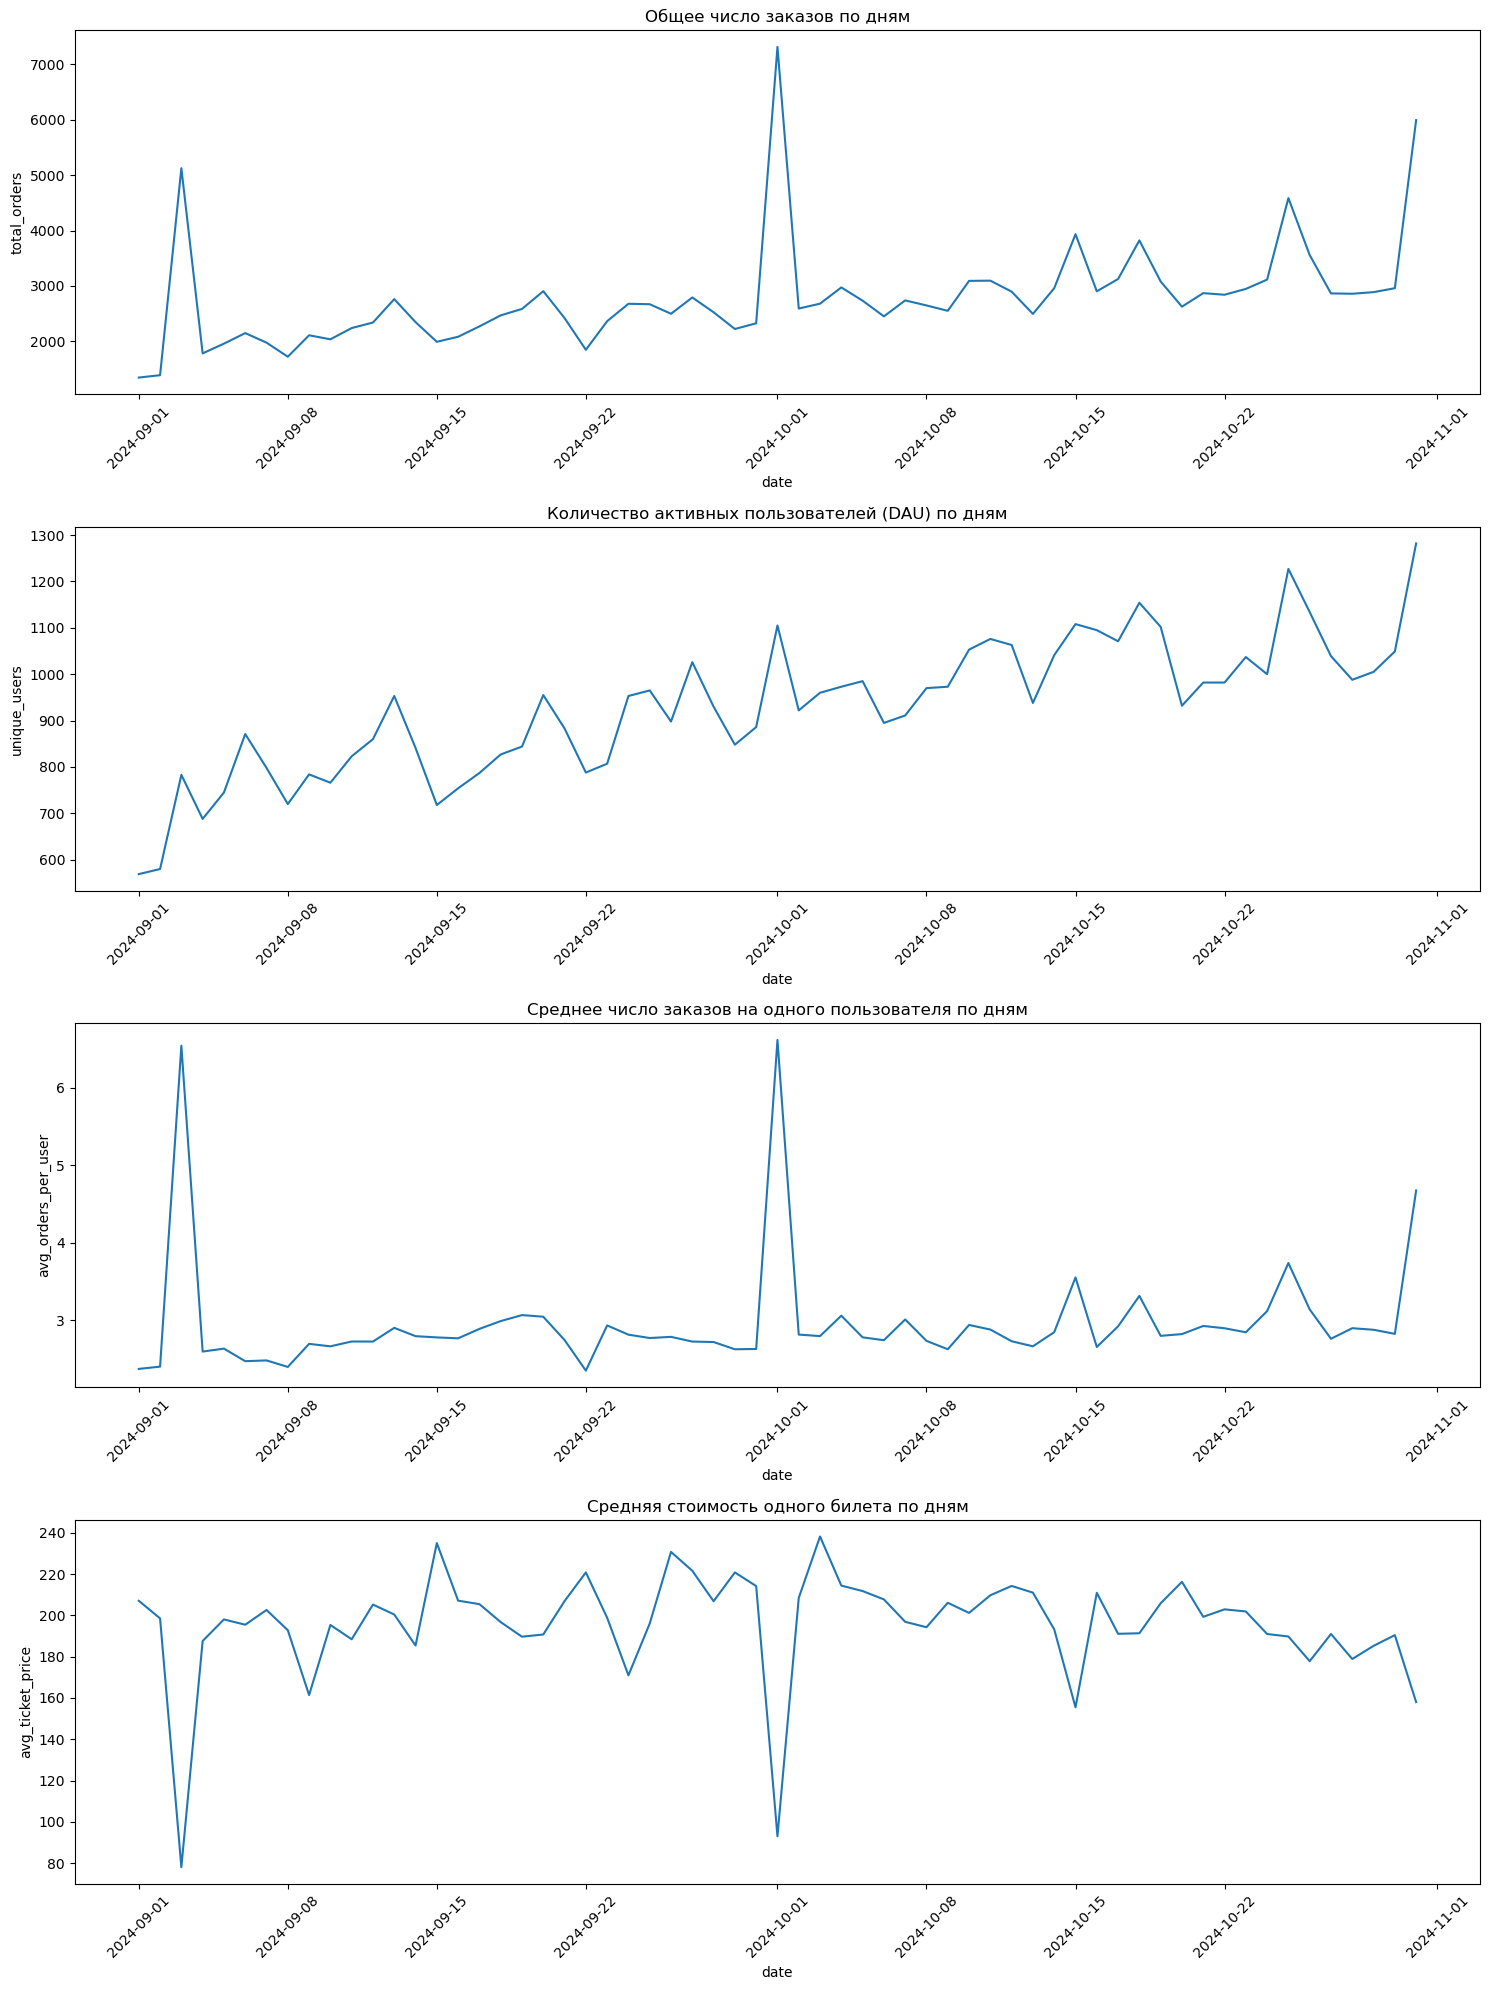

In [34]:
# Визуализация
fig, axes = plt.subplots(4, 1, figsize=(15, 20))

# Общее число заказов
sns.lineplot(ax=axes[0], x='date', y='total_orders', data=daily_summary)
axes[0].set_title('Общее число заказов по дням')
axes[0].tick_params(axis='x', rotation=45)

# Количество активных пользователей (DAU)
sns.lineplot(ax=axes[1], x='date', y='unique_users', data=daily_summary)
axes[1].set_title('Количество активных пользователей (DAU) по дням')
axes[1].tick_params(axis='x', rotation=45)

# Среднее число заказов на одного пользователя
sns.lineplot(ax=axes[2], x='date', y='avg_orders_per_user', data=daily_summary)
axes[2].set_title('Среднее число заказов на одного пользователя по дням')
axes[2].tick_params(axis='x', rotation=45)

# Средняя стоимость одного билета
sns.lineplot(ax=axes[3], x='date', y='avg_ticket_price', data=daily_summary)
axes[3].set_title('Средняя стоимость одного билета по дням')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Выводы:

- Общее число заказов демонстрирует значительную волатильность с резкими всплесками в отдельные дни (3 сентября, 1 октября и 31 октября). Это может быть связано с акциями, событиями или внешними факторами. В остальное время наблюдаются колебания, но без явного тренда к росту или падению.

- Динамика DAU в целом коррелирует с динамикой общего числа заказов. Рост DAU, вероятно, является одним из факторов, влияющих на рост заказов. В течение октября наблюдается относительно стабильный уровень DAU, с колебаниями, возможно, вызванными маркетинговыми кампаниями или другими факторами.

- Резкие скачки среднего числа заказов на пользователя (3 сентября и 1 октября) указывают на периоды высокой активности существующих пользователей. В остальное время среднее число заказов на пользователя относительно стабильное, что говорит о том, что новые пользователи не оказывают существенного влияния на этот показатель.

- Средняя цена билета также подвержена значительным колебаниям. Резкие снижения цены (3 сентября и 1 октября) могут быть связаны с распродажами, акциями или изменениями в структуре продаваемых билетов (например, увеличение доли более дешевых билетов). Высокая волатильность в октябре может указывать на активное использование скидок и акций для привлечения пользователей.

 Изучим пользовательскую активность в будни и выходные.

In [35]:
# Выделим день недели
autumn_df['day_of_week'] = autumn_df['created_dt_msk'].dt.day_name()

# Создадим столбец, показывающий, является ли день выходным
autumn_df['is_weekend'] = autumn_df['day_of_week'].isin(['Saturday', 'Sunday'])

# Сравним пользовательскую активность в будни и выходные
weekday_weekend_summary = autumn_df.groupby('is_weekend').agg(
    total_orders=('order_id', 'count'),
    unique_users=('user_id', 'nunique'),
    avg_revenue=('revenue_rub', 'mean')
).reset_index()

weekday_weekend_summary['is_weekend'] = weekday_weekend_summary['is_weekend'].map({False: 'Будни', True: 'Выходные'})

Визуализируем полученные результаты с помощью столбчатой диаграммы. 

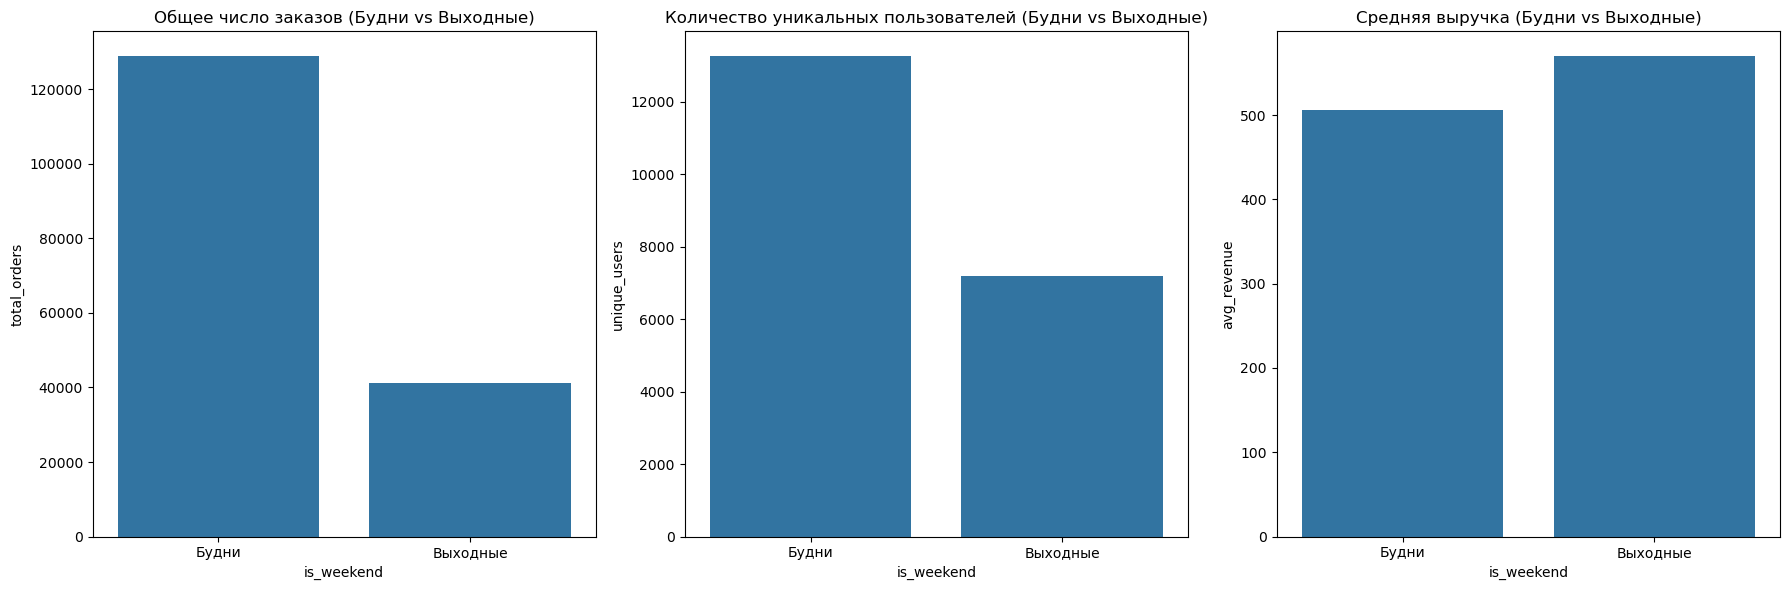

In [36]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Общее число заказов
sns.barplot(ax=axes[0], x='is_weekend', y='total_orders', data=weekday_weekend_summary)
axes[0].set_title('Общее число заказов (Будни vs Выходные)')

# Количество уникальных пользователей
sns.barplot(ax=axes[1], x='is_weekend', y='unique_users', data=weekday_weekend_summary)
axes[1].set_title('Количество уникальных пользователей (Будни vs Выходные)')

# Средняя выручка
sns.barplot(ax=axes[2], x='is_weekend', y='avg_revenue', data=weekday_weekend_summary)
axes[2].set_title('Средняя выручка (Будни vs Выходные)')

plt.tight_layout()
plt.show()

Результаты показывают, что:

- В будни совершается значительно больше заказов (129051), чем в выходные (41124). Это может быть связано с общим уровнем активности пользователей, доступностью товаров/услуг, или маркетинговыми кампаниями, ориентированными на будние дни.
- В будни также больше уникальных пользователей (13279), чем в выходные (7202). Это напрямую связано с большим количеством заказов.
- Средняя выручка на один заказ выше в выходные (570.56 руб.), чем в будни (506.22 руб.). Это может указывать на то, что в выходные пользователи склонны делать более дорогие покупки. Возможные причины:
Больше времени на выбор товаров.
Покупки для развлечения или особых случаев.
Меньшая чувствительность к цене в выходные.

Промежуточный вывод: Анализ осенней активности пользователей (сентябрь-октябрь 2024)
- Проведенный анализ показывает значительную волатильность в активности пользователей в сентябре и октябре 2024 года. Наблюдаются резкие всплески в общем числе заказов, DAU и среднем числе заказов на пользователя, что, вероятно, связано с акциями, событиями или внешними факторами. Средняя цена билета также подвержена колебаниям, указывая на активное использование скидок.
- Наблюдается существенная разница в активности между буднями и выходными.
Будни: Больше заказов и уникальных пользователей.
Выходные: Более высокая средняя выручка на один заказ.

Изучим, как события распределены по регионам и партнёрам. Посчитаем уникальное количество мероприятий и общее число заказов. 

In [37]:
# Группируем по регионам и подсчитываем уникальные мероприятия и заказы
region_analysis = full_df.groupby('region_name').agg(
    {'event_id': 'nunique', 'order_id': 'count', 'revenue_rub': 'sum'}
).reset_index()
region_analysis.rename(
    columns={'event_id': 'unique_events', 'order_id': 'total_orders', 'revenue_rub': 'total_revenue'}, inplace=True)

# Расчет доли мероприятий и заказов
total_events = region_analysis['unique_events'].sum()
total_orders = region_analysis['total_orders'].sum()
region_analysis['event_share'] = region_analysis['unique_events'] / total_events
region_analysis['order_share'] = region_analysis['total_orders'] / total_orders

# Сортировка по количеству уникальных мероприятий для вывода
region_analysis_sorted_events = region_analysis.sort_values(by='unique_events', ascending=False)
display("Анализ по регионам (сортировка по количеству уникальных мероприятий):\n", region_analysis_sorted_events)

'Анализ по регионам (сортировка по количеству уникальных мероприятий):\n'

,region_name,unique_events,total_orders,total_revenue,event_share,order_share
23,Каменевский регион,5983,91058,6.126324e+07,0.266777,0.313333
60,Североярская область,3814,44049,2.533894e+07,0.170063,0.151574
77,Широковская область,1233,16457,9.509246e+06,0.054978,0.056629
57,Светополянский округ,1075,7607,3.415026e+06,0.047933,0.026176
52,Речиновская область,702,6293,2.706757e+06,0.031302,0.021654
...,...,...,...,...,...,...
5,Верхозёрский край,2,11,2.180020e+03,0.000089,0.000038
33,Лесноярский край,2,19,3.779160e+03,0.000089,0.000065
56,Светолесский край,2,24,1.041429e+04,0.000089,0.000083
66,Сосноводолинская область,2,10,1.746950e+03,0.000089,0.000034


Наибольшее разнообразие мероприятий предлагается в Каменевском регионе, так как у него наибольшее значение уникальных мероприятий (unique_events - 5983). Далее следуют Североярская область, Широковская область и другие, в порядке убывания количества уникальных мероприятий.

Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

In [38]:
# Группируем по партнерам и подсчитываем статистику
partner_analysis = full_df.groupby('service_name').agg(
    {'event_id': 'nunique', 'order_id': 'count', 'revenue_rub': 'sum'}
).reset_index()
partner_analysis.rename(
    columns={'event_id': 'unique_events', 'order_id': 'total_orders', 'revenue_rub': 'total_revenue'}, inplace=True)

# Расчет долей
total_events_partners = partner_analysis['unique_events'].sum()
total_orders_partners = partner_analysis['total_orders'].sum()
partner_analysis['event_share'] = partner_analysis['unique_events'] / total_events_partners
partner_analysis['order_share'] = partner_analysis['total_orders'] / total_orders_partners

# Сортировка по общей выручке для вывода
partner_analysis_sorted_revenue = partner_analysis.sort_values(by='total_revenue', ascending=False)
display("\nАнализ по билетным партнёрам (сортировка по выручке):\n", partner_analysis_sorted_revenue)

'\nАнализ по билетным партнёрам (сортировка по выручке):\n'

,service_name,unique_events,total_orders,total_revenue,event_share,order_share
3,билеты без проблем,4255,63519,2.670785e+07,0.173908,0.218571
24,мой билет,1308,34839,2.347865e+07,0.053460,0.119882
25,облачко,2348,26642,2.164407e+07,0.095966,0.091676
8,весь в билетах,867,16849,1.804930e+07,0.035435,0.057978
21,лови билет!,4882,41124,1.766531e+07,0.199534,0.141509
5,билеты в руки,3538,40343,1.338539e+07,0.144603,0.138821
19,край билетов,253,6207,6.703959e+06,0.010340,0.021358
26,прачечная,1027,10273,4.900985e+06,0.041975,0.035350
13,дом культуры,274,4502,4.676648e+06,0.011199,0.015491
35,яблоко,716,5039,3.971152e+06,0.029264,0.017339


Промежуточный вывод:

Данные демонстрируют неравномерное распределение активности как по регионам, так и по билетным партнерам.

Регионы: Каменевский регион - явный лидер по количеству мероприятий и выручке. Остальные регионы значительно отстают, хотя наблюдается общая тенденция, что большее количество мероприятий приводит к большему количеству заказов.

Партнеры: “билеты без проблем” доминирует по выручке, но “лови билет!” обрабатывает наибольшее количество уникальных мероприятий. Рынок билетных партнеров можно охарактеризовать как концентрированный, с несколькими крупными игроками и большим количеством небольших партнеров, возможно, работающих в нишевых сегментах.

## Статистический анализ данных

В статистическом анализе необходимо проверить две гипотезы: 
- Гипотеза 1: Среднее количество заказов, сделанных пользователем мобильного приложения, выше, чем среднее количество заказов, сделанных пользователем стационарного устройства.
- Гипотеза 2: Пользователи мобильных устройств проводят в среднем больше времени в приложении, чем пользователи стационарных устройств.

Перед проверкой двух гипотез изучим сравниваемые данные

Сравним размеры выборок исследуемых групп для гипотезы 1

In [39]:
# Подготовка данных для гипотезы 1
mobile_orders = autumn_df[autumn_df['device_type_canonical'] == 'mobile'].groupby('user_id')['order_id'].count()
desktop_orders = autumn_df[autumn_df['device_type_canonical'] == 'desktop'].groupby('user_id')['order_id'].count()

# Проверка размеров выборок
print(f"Размер выборки mobile_orders: {len(mobile_orders)}")
print(f"Размер выборки desktop_orders: {len(desktop_orders)}")

Размер выборки mobile_orders: 14239
Размер выборки desktop_orders: 4906


Размер выборок существенно отличается, что может повлиять на результаты анализа. Чтобы уменьшить эту проблему, можно использовать сэмплирование (случайная выборка).


In [40]:
# Задаем размер меньшей выборки
sample_size = min(len(mobile_orders), len(desktop_orders))  # Берем минимальный размер

# Сэмплируем каждую выборку до заданного размера
mobile_orders_sampled = mobile_orders.sample(n=sample_size, random_state=42)  # Добавляем random_state для воспроизводимости
desktop_orders_sampled = desktop_orders.sample(n=sample_size, random_state=42) # Добавляем random_state для воспроизводимости

# Проверяем размеры сэмплированных выборок
print(f"Размер сэмплированной выборки mobile_orders: {len(mobile_orders_sampled)}")
print(f"Размер сэмплированной выборки desktop_orders: {len(desktop_orders_sampled)}")


Размер сэмплированной выборки mobile_orders: 4906
Размер сэмплированной выборки desktop_orders: 4906


Изучим нормальность распределения данных и равенство дисперсий.

In [41]:
# Фильтрация данных за осенний период (сентябрь-октябрь 2024).  
autumn_df = full_df[(full_df['month'].isin([9, 10])) & (full_df['created_dt_msk'].dt.year == 2024)]

# Подготовка данных для гипотезы 1
mobile_orders = autumn_df[autumn_df['device_type_canonical'] == 'mobile'].groupby('user_id')['order_id'].count()
desktop_orders = autumn_df[autumn_df['device_type_canonical'] == 'desktop'].groupby('user_id')['order_id'].count()

# Проверка нормальности (тест Шапиро-Уилка):
alpha = 0.05  # Уровень значимости

shapiro_mobile = stats.shapiro(mobile_orders)
shapiro_desktop = stats.shapiro(desktop_orders)

print(f"Shapiro-Wilk test for Mobile Orders: {shapiro_mobile}")
print(f"Shapiro-Wilk test for Desktop Orders: {shapiro_desktop}")

# Проверка равенства дисперсий (тест Левена):
levene = stats.levene(mobile_orders, desktop_orders)
print(f"Levene test for equality of variances: {levene}")

Shapiro-Wilk test for Mobile Orders: ShapiroResult(statistic=np.float64(0.07802846904707172), pvalue=np.float64(2.1868092386084557e-123))
Shapiro-Wilk test for Desktop Orders: ShapiroResult(statistic=np.float64(0.1248543011472577), pvalue=np.float64(3.2090410815469986e-92))
Levene test for equality of variances: LeveneResult(statistic=np.float64(5.468734760154679), pvalue=np.float64(0.019369872585349873))


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14239.
  res = hypotest_fun_out(*samples, **kwds)


Поскольку данные не распределены нормально (p-value меньше уровня значимости alpha (0.05) для обеих групп и дисперсии не равны (p-value меньше уровня значимости alpha (0.05)), следует использовать непараметрический тест Манна-Уитни. Этот тест не требует предположений о нормальности распределения.

Перед проведением непараметрического теста Манна-Уитни для гипотезы 1 сформулируем нулевую и альтернативную гипотезы

- Нулевая гипотеза (H₀): Среднее количество заказов на одного пользователя мобильного приложения не больше, чем среднее количество заказов на одного пользователя стационарного устройства. (μ_mobile <= μ_desktop)

- Альтернативная гипотеза (H₁): Среднее количество заказов на одного пользователя мобильного приложения больше, чем среднее количество заказов на одного пользователя стационарного устройства. (μ_mobile > μ_desktop)

In [42]:
# Проводим тест Манна-Уитни
u, p = stats.mannwhitneyu(mobile_orders_sampled, desktop_orders_sampled, alternative='greater')

print(f"Mann-Whitney U statistic: {u}")
print(f"P-value: {p}")

alpha = 0.05
if p < alpha:
    print("Отвергаем нулевую гипотезу: Среднее количество заказов с мобильных устройств статистически значимо больше, чем с десктопных.")
else:
    print("Не можем отвергнуть нулевую гипотезу.")

Mann-Whitney U statistic: 12537279.5
P-value: 8.826754075921788e-05
Отвергаем нулевую гипотезу: Среднее количество заказов с мобильных устройств статистически значимо больше, чем с десктопных.


На основе результатов теста, можно заключить, что среднее количество заказов, сделанных в приложении пользователями мобильных устройств, статистически значимо больше, чем среднее количество заказов,сделанных пользователями стационарных устройств.

Перед проведением непараметрического теста Манна-Уитни для гипотезы 2 сформулируем нулевую и альтернативную гипотезы

- Нулевая гипотеза (H₀): Среднее время, проведенное в приложении пользователями мобильных устройств, не больше, чем среднее время, проведенное пользователями стационарных устройств. (μ_mobile <= μ_desktop)

- Альтернативная гипотеза (H₁): Среднее время, проведенное в приложении пользователями мобильных устройств, больше, чем среднее время, проведенное пользователями стационарных устройств. (μ_mobile > μ_desktop)

In [43]:
# Подготовка данных для гипотезы 2 (используем days_since_prev)
mobile_session_duration = autumn_df[autumn_df['device_type_canonical'] == 'mobile'].groupby('user_id')['days_since_prev'].mean()
desktop_session_duration = autumn_df[autumn_df['device_type_canonical'] == 'desktop'].groupby('user_id')['days_since_prev'].mean()



Сравним размеры выборок исследуемых групп для гипотезы 2

In [44]:
# Проверка размеров выборок для session_duration
print(f"Размер выборки mobile_session_duration: {len(mobile_session_duration)}")
print(f"Размер выборки desktop_session_duration: {len(desktop_session_duration)}")

Размер выборки mobile_session_duration: 14239
Размер выборки desktop_session_duration: 4906


Размер выборок существенно отличается, что может повлиять на результаты анализа. Чтобы уменьшить эту проблему, можно использовать сэмплирование (случайная выборка).

In [45]:
# Задаем размер меньшей выборки для session_duration
sample_size_session = min(len(mobile_session_duration), len(desktop_session_duration))

# Сэмплируем каждую выборку до заданного размера для session_duration
mobile_session_sampled = mobile_session_duration.sample(n=sample_size_session, random_state=42)
desktop_session_sampled = desktop_session_duration.sample(n=sample_size_session, random_state=42)

# Проверяем размеры сэмплированных выборок
print(f"Размер сэмплированной выборки mobile_orders: {len(mobile_session_sampled)}")
print(f"Размер сэмплированной выборки desktop_orders: {len(desktop_session_sampled)}")

Размер сэмплированной выборки mobile_orders: 4906
Размер сэмплированной выборки desktop_orders: 4906


Изучим нормальность распределения данных и равенство дисперсий.

In [46]:
# Проверка нормальности (тест Шапиро-Уилка) для session_duration:
shapiro_mobile_session = stats.shapiro(mobile_session_duration)
shapiro_desktop_session = stats.shapiro(desktop_session_duration)

print(f"Shapiro-Wilk test for Mobile Session Duration: {shapiro_mobile_session}")
print(f"Shapiro-Wilk test for Desktop Session Duration: {shapiro_desktop_session}")

# Проверка равенства дисперсий (тест Левена) для session_duration:
levene_session = stats.levene(mobile_session_duration, desktop_session_duration)
print(f"Levene test for equality of variances (Session Duration): {levene_session}")



Shapiro-Wilk test for Mobile Session Duration: ShapiroResult(statistic=np.float64(0.634296943869544), pvalue=np.float64(4.279909842168068e-99))
Shapiro-Wilk test for Desktop Session Duration: ShapiroResult(statistic=np.float64(0.5895757846482721), pvalue=np.float64(1.6966511060606488e-75))
Levene test for equality of variances (Session Duration): LeveneResult(statistic=np.float64(36.36112797011342), pvalue=np.float64(1.6694866811397516e-09))


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14239.
  res = hypotest_fun_out(*samples, **kwds)


Поскольку данные не распределены нормально (p-value меньше уровня значимости alpha (0.05) для обеих групп и дисперсии не равны (p-value меньше уровня значимости alpha (0.05)), следует использовать непараметрический тест Манна-Уитни. Этот тест не требует предположений о нормальности распределения.

In [47]:
# Проводим тест Манна-Уитни для session_duration
u_session, p_session = stats.mannwhitneyu(mobile_session_sampled, desktop_session_sampled, alternative='greater')

print(f"Mann-Whitney U statistic (Session Duration): {u_session}")
print(f"P-value (Session Duration): {p_session}")

alpha = 0.05
if p_session < alpha:
    print("Отвергаем нулевую гипотезу: Среднее время, проведенное в приложении с мобильных устройств, статистически значимо больше, чем с десктопных.")
else:
    print("Не можем отвергнуть нулевую гипотезу: Нет статистически значимых доказательств, что среднее время, проведенное в приложении с мобильных устройств, больше, чем с десктопных.")

Mann-Whitney U statistic (Session Duration): 11888939.0
P-value (Session Duration): 0.854565747814357
Не можем отвергнуть нулевую гипотезу: Нет статистически значимых доказательств, что среднее время, проведенное в приложении с мобильных устройств, больше, чем с десктопных.


Поскольку 0.854565747814357 > 0.05, p-значение больше уровня значимости. Следовательно, вы не можете отвергнуть нулевую гипотезу. Другими словами, на основании ваших данных, нет достаточно доказательств, чтобы сказать, что среднее время сеанса с мобильных устройств статистически значимо больше, чем с десктопов.

Промежуточные выводы: 
- Размеры выборок для проверки обеих гипотез значительно различались, поэтому было проведено сэмплирование для уравнивания размеров.

- Тест Шапиро-Уилка показал, что данные не распределены нормально. Тест Левена указал на неравенство дисперсий.

- Был применен непараметрический тест Манна-Уитни, который показал, что: 

- Среднее количество заказов, сделанных пользователями мобильных устройств, статистически значимо больше, чем среднее количество заказов, сделанных пользователями десктопных устройств.

- Нет статистически значимых доказательств того, что среднее время, проведенное в приложении пользователями мобильных устройств, больше, чем среднее время, проведенное пользователями десктопных устройств.



## Общий вывод и рекомендации

### Информация о данных:

- Для анализа было представлено три датасета: информация о заказах билетов, информация о мероприятиях и информация о курсе тенге к рублю.
- Основной период анализа: с 1 июня по 30 октября 2024 года.
- Данные содержали информацию о заказах, пользователях, мероприятиях, типах устройств, выручке, билетных операторах и регионах.

### Основные результаты анализа:

- Осенью возросла популярность концертов, театральных постановок, спортивных событий и “ёлок”.
- Общее количество заказов увеличилось в осенний период по сравнению с летом. Увеличение доли заказов с десктопов выросло.
- Средняя стоимость билета на выставки и стендап увеличилась осенью, в то время как средняя стоимость билетов на концерты, театр, спорт и “ёлки” снизилась.

### Информация о пользовательской активности: 
- Анализ активности пользователей в сентябре и октябре 2024 года показывает значительную волатильность с резкими всплесками в общем числе заказов. В будни совершается больше заказов, чем в выходные, но средняя выручка с заказа в выходные выше.

- Лидеры по заказам и выручке: Каменевский регион является явным лидером по количеству мероприятий и выручке. Среди билетных партнеров лидирует “Билеты без проблем” по выручке, а “Лови билет!” - по количеству уникальных мероприятий.

- Обнаружена значительная разница в активности между пользователями мобильных и стационарных устройств.

### Результаты проверки гипотез:

- Гипотеза 1: Подтверждена. Среднее количество заказов, сделанных пользователями мобильных устройств, статистически значимо выше, чем среднее количество заказов, сделанных пользователями стационарных устройств.
- Гипотеза 2: Не подтверждена. Нет статистически значимых доказательств того, что среднее время, проведенное в приложении пользователями мобильных устройств, больше, чем среднее время, проведенное пользователями стационарных устройств.

### Рекомендации:

- Усилить маркетинговые усилия на мобильных устройствах: Учитывая, что пользователи мобильных устройств делают больше заказов, следует оптимизировать интерфейс и маркетинговые кампании для мобильных платформ.
- Разработать стратегии для выходных дней: Средняя выручка с заказа выше в выходные, поэтому необходимо разработать стратегии (например, специальные предложения или акции), чтобы стимулировать увеличение количества заказов в выходные дни.
- Учитывать сезонные изменения: Адаптировать ассортимент мероприятий и ценовую политику в зависимости от сезона, учитывая изменение потребительских предпочтений.
- Усилить партнерские отношения с “Билеты без проблем” и “Лови билет!”, чтобы максимально использовать их возможности по привлечению пользователей и увеличению выручки.
- Изучить причины волатильности в осенний период: Провести дополнительное исследование, чтобы выявить причины резких всплесков и падений в активности пользователей в сентябре и октябре, чтобы лучше планировать маркетинговые кампании и управлять запасами билетов.
- Провести A/B тестирование для мобильных и десктопных версий: Несмотря на то, что гипотеза о большем времени, проведенном в приложении с мобильных устройств, не подтвердилась, рекомендуется провести A/B тестирование для мобильных и десктопных версий приложения, чтобы выявить факторы, влияющие на вовлеченность пользователей.